In [154]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import time
import scipy.stats as stats
from tabulate import tabulate
from itertools import combinations


In [3]:
"""
Classes
"""
class Cities:
    def __init__(self, csv):
        """
        Class containing all city objects

        Args:
        - Txt file containing cities and coordinates
        """
        # opens file
        with open(csv, "r") as f:
            lines = f.readlines()

        # reads all lines and adds them to a pandas table
        lines = lines[6:-1]
        stripped_lines = [line.strip() for line in lines]
        numbers = [[int(part) for part in line.split()] for line in stripped_lines]
        self.df = pd.DataFrame(numbers, columns=["city", "Longitude", "Latitude"])
        self.df = self.df.iloc[:, 1:]

        # add all city objects
        self.city = []
        for index, row in self.df.iterrows():
            self.city.append(City(row.name, row["Longitude"], row["Latitude"]))

class City:
    """
    Class to create one city object

    Args:
    - City integer
    - X coordinate
    - Y coordinate
    """
    def __init__(self, city, x, y):
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    """
    Class containing a certain route

    Args:
    - List[A,B] A = 1 B = The amount of cities in the route
    - Cities class, making it possible to link to all city objects
    - Perturbation, specifying the preferred perturbation when initializing
    """
    def __init__(self, list, cities_class, perturbation):
        self.cities = np.random.choice(range(list[1]), size=list[1], replace=False)
        self.route = []
        for i in self.cities:
            self.route.append(cities_class.city[i])
        self.distance = self.calculate_distance()
        self.old_route = []
        self.cities_class = cities_class
        self.perturbation = perturbation
        if self.perturbation == "two_opt":
            self.perturbation = self.two_opt
        elif self.perturbation == "move_single":
            self.perturbation = self.move_single
        else:
            raise ValueError("perturbation does not exist")


    def two_opt(self):
        """
        Performs 2-opt on the current route

        Saves the old route as well
        """
        self.old_route = self.route.copy()
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])

    def move_single(self):
        """
        Moves a single city to another location in the route
        """
        self.old_route = self.route.copy()
        # random index to move
        from_index = np.random.randint(0, len(self.route) - 1)

        # new random location for the element
        to_index = np.random.randint(0, len(self.route) - 1)

        # remove the element at from_index
        element = self.route.pop(from_index)

        # insert the element at the new location
        self.route.insert(to_index, element)

    def calculate_distance(self):
        """
        Calculates the total distance of the route
        """
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        self.distance = distance
        return distance
    
    def plot(self):
        """
        plots the route

        From: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
        """

        geometry = [Point(xy) for xy in zip(self.cities_class.df['Longitude'], self.cities_class.df['Latitude'])]
        gdf = GeoDataFrame(self.cities_class.df, geometry=geometry)   

        world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

        gdf_filtered = gdf[(gdf['Longitude'] > 0) & (gdf['Latitude'] > 0)]
        minx, miny, maxx, maxy = gdf_filtered.total_bounds  

        route_coordinates = [(city.x, city.y) for city in self.route]
        route_coordinates.append((self.route[0].x, self.route[0].y))

        # create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='black', markersize=20)
        # route
        route_gdf.plot(ax=ax, color='blue', linewidth=1)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

In [4]:
def load_tour(tour_file):
    """
    Load the optimal tour from the TSP tour file.
    """
    tour = []
    with open(tour_file, "r") as file:
        lines = file.readlines()
        tour_section = False
        for line in lines:
            if "TOUR_SECTION" in line:
                tour_section = True
                continue
            if tour_section:
                city_id = int(line.strip())
                if city_id == -1:
                    break
                tour.append(city_id)
    return tour

load_tour('eil51.opt.tour.txt')

[1,
 22,
 8,
 26,
 31,
 28,
 3,
 36,
 35,
 20,
 2,
 29,
 21,
 16,
 50,
 34,
 30,
 9,
 49,
 10,
 39,
 33,
 45,
 15,
 44,
 42,
 40,
 19,
 41,
 13,
 25,
 14,
 24,
 43,
 7,
 23,
 48,
 6,
 27,
 51,
 46,
 12,
 47,
 18,
 4,
 17,
 37,
 5,
 38,
 11,
 32]

In [5]:
cities = Cities("a280.tsp.txt")
route = Route([1,280], cities, "two_opt")
print(route.route)



[|City nr. 30 at x=104, y=161|, |City nr. 146 at x=172, y=69|, |City nr. 170 at x=80, y=25|, |City nr. 103 at x=56, y=41|, |City nr. 250 at x=260, y=85|, |City nr. 82 at x=32, y=65|, |City nr. 127 at x=132, y=145|, |City nr. 272 at x=212, y=145|, |City nr. 24 at x=156, y=169|, |City nr. 38 at x=56, y=153|, |City nr. 113 at x=56, y=73|, |City nr. 138 at x=172, y=85|, |City nr. 101 at x=56, y=25|, |City nr. 39 at x=56, y=145|, |City nr. 70 at x=8, y=89|, |City nr. 3 at x=256, y=141|, |City nr. 216 at x=228, y=37|, |City nr. 2 at x=270, y=133|, |City nr. 247 at x=260, y=109|, |City nr. 112 at x=48, y=73|, |City nr. 50 at x=32, y=169|, |City nr. 41 at x=56, y=129|, |City nr. 100 at x=56, y=17|, |City nr. 176 at x=124, y=77|, |City nr. 102 at x=56, y=33|, |City nr. 31 at x=104, y=169|, |City nr. 164 at x=104, y=17|, |City nr. 79 at x=32, y=41|, |City nr. 4 at x=256, y=157|, |City nr. 60 at x=56, y=105|, |City nr. 245 at x=276, y=85|, |City nr. 224 at x=260, y=37|, |City nr. 95 at x=16, y=17

37
42.04759208325728
1729.5284162959997


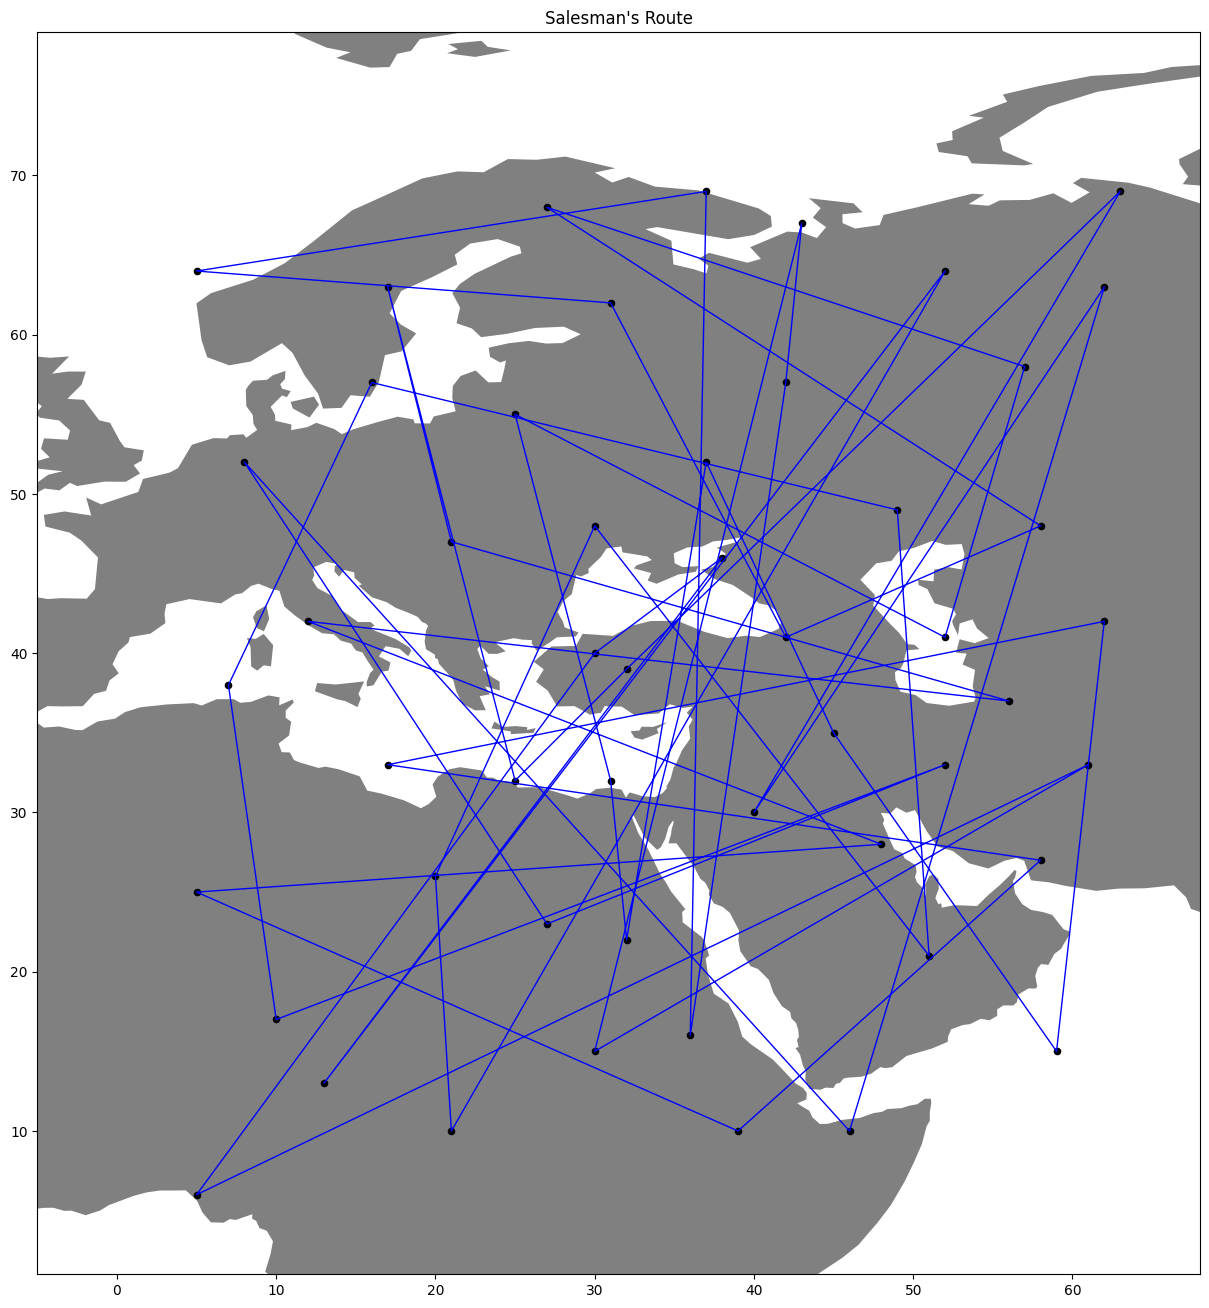

In [6]:
"""
USAGE EXAMPLES
"""
cities = Cities("eil51.tsp.txt")

print(cities.city[0].x)
print(cities.city[0].get_distance_to(cities.city[44]))

# define as the first city to the 51st city
route = Route([1,51], cities, "two_opt")
print(route.calculate_distance())
route.two_opt()
route.plot()

In [37]:
"""
Simulated Annealing
"""
class SimmulatedAnnealing:
    """
    Class for simmulated Annealing

    Args:
    - The amount of cities in the txt file
    - txt file with the cities

    Usage:
    annealing = SimmulatedAnnealing(x,x)
    ...
    specify parameters
    ...
    annealing.run(y), where y is the amount of different runs 

    Notes:
    - Set all preferred variables beforehand otherwise it will take default values
    """
    def __init__(self, cities_amount,csv):
        self.init_temp = 1
        self.final_temp = 0.01
        self.cooling_rate = 0.95
        self.iterations = 100
        self.cities_amount = cities_amount
        self.cities = Cities(csv)
        self.mean = []
        self.sd = []
        self.data = []
        self.final_routes = []
        self.measurement_interval = 1
        self.perturbation = "two_opt"
        self.cooling_method = self.cooling_linear

        self.temp_data = None
        self.acceptance_rates = None

    def run(self, runs):
        """
        Runs annealing
        """
        if self.iterations % self.measurement_interval != 0:
            raise ValueError("Iterations divided by measurement interval must be a whole number")

        self.data = np.zeros((runs, int(self.iterations/self.measurement_interval)))
        self.temp_data = np.zeros((runs, int(self.iterations/self.measurement_interval)))
        self.acceptance_rates = np.zeros((runs, int(self.iterations/self.measurement_interval)))

        for i in trange(runs):
            # if i % 5 == 0:
            #     print(f"run {i} with {self.perturbation}")
            solutions_list = np.zeros(int(self.iterations/self.measurement_interval))
            temperature_list = np.zeros(int(self.iterations/self.measurement_interval))
            acceptance_list = np.zeros(int(self.iterations/self.measurement_interval))

            accepted_worse = 0
            total_attempts = 0

            # create new route
            route = Route([1,self.cities_amount], self.cities, self.perturbation)
            current_solution = route.calculate_distance()
            solutions_list[0] = current_solution
            current_temp = self.init_temp
            temperature_list[0] = current_temp
            acceptance_list[0] = 0.0
            # temperatures = [current_temp]

            # iterate until the temperature is below the final temperature
            # while current_temp > self.final_temp:
            for j in range(1, self.iterations):
                total_attempts += 1
                # perturb 
                route.perturbation()
                perturbed_solution = route.calculate_distance()

                # define delta and accepting probability
                delta = perturbed_solution - current_solution
                exponent = min(-delta / current_temp, 700)
                probability = math.exp(exponent) 

                # if perturbed solution is better accept it as the new solution
                if delta < 0: 
                    current_solution = perturbed_solution
                # if it is worse accept it with certain probability
                elif np.random.random() < probability:
                    current_solution = perturbed_solution
                    accepted_worse += 1
                else:
                    route.route = route.old_route.copy()
                    current_solution = route.calculate_distance()

                # decrease temperature according to cooling rate
                if self.cooling_method == self.cooling_logarithmic:
                    current_temp = self.cooling_method(self.init_temp, self.final_temp, j, self.iterations)
                else:
                    current_temp = self.cooling_method(self.init_temp, self.final_temp, j, self.iterations)

                # if current_temp < self.final_temp:
                #     break
                if j % self.measurement_interval == 0:
                    index = int(j / self.measurement_interval)
                    solutions_list[int(j/self.measurement_interval)] = current_solution
                    temperature_list[int(j/self.measurement_interval)] = current_temp
                    acceptance_list[index] = accepted_worse / total_attempts

                # temperatures.append(current_temp)
            
            self.final_routes.append(route)
            self.data[i] = solutions_list
            self.temp_data[i] = temperature_list
            self.acceptance_rates[i] = acceptance_list

    def give_sd_at(self, iteration):
        """
        Returns standard deviation at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.std(self.data[:, iteration])

    def give_mean_at(self, iteration):
        """
        Returns mean at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.mean(self.data[:, iteration])

    def give_all_means(self):
        """
        Returns means over all runs at all iterations in a list 
        """
        return np.mean(self.data, axis=0).tolist()
    
    def give_all_temps_mean(self):
        return np.mean(self.temp_data, axis=0).tolist()

    def give_all_sd(self):
        """
        Returns standard deviation over all runs at all iterations in a list
        """
        return np.std(self.data, axis=0).tolist()
    
    def give_ci_at(self, iteration):
        """
        Returns confidence interval at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        std_dev = np.std(self.data[:, iteration])
        n = self.data.shape[0] 
        return (1.96 * std_dev / np.sqrt(n))

    def give_all_ci(self):
        """
        Returns confidence interval over all runs at all iterations in a list
        """
        std_devs = np.std(self.data, axis=0)
        n = self.data.shape[0]
        #print(n)  
        return (1.96 * std_devs / np.sqrt(n)).tolist()
    
    def range(self):
        """
        Returns the amount of datapoints 

        Note: useful for plotting
        """
        return int(self.iterations/self.measurement_interval)
    
    @staticmethod
    def cooling_linear(temp_start, final_temp, iteration, iterations):
        new_temp = temp_start - iteration * (temp_start - final_temp)/iterations
        return new_temp
    
    @staticmethod
    def cooling_exponential(temp_start, final_temp, iteration, iterations):
        a = (final_temp / temp_start) ** (1 / iterations)
        T = temp_start * (a ** iteration)
        
        return T
    
    
    @staticmethod
    def cooling_logarithmic(temp_start, final_temp, iteration, iterations):
        # C = temp_start * np.log(1 + iterations) / (temp_start - final_temp)
        # T = C / np.log(1 + iterations)
        # C = temp_start * np.log(1 + iterations)
        # T = C / np.log(1 + iteration)

        scale = math.log(1 + iterations)  # Scaling factor for the entire process
        current_log = math.log(1 + iteration)  # Current logarithmic value
        temp = final_temp + (temp_start - final_temp) * (scale - current_log) / scale

        
        return temp

    def set_cooling_method(self, method):
        if method == "linear":
            self.cooling_method = self.cooling_linear
        elif method == "exponential":
            self.cooling_method = self.cooling_exponential
        elif method == "logarithmic":
            self.cooling_method = self.cooling_logarithmic
        else:
            raise ValueError(f"Unknown cooling method: {method}")


In [5]:
"""
Using it
"""
cooling_rates = [0.999, 0.95, 0.9]

two_opt_list = []
move_single_list = []

for i in range(len(cooling_rates)):
    annealing = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing.cooling_rate = cooling_rates[i]
    annealing.final_temp = 0.0001
    annealing.init_temp = 2
    annealing.iterations = 5000
    annealing.measurement_interval = 10
    annealing.perturbation = "two_opt"
    annealing.run(10)
    two_opt_list.append(annealing)

    annealing_move = SimmulatedAnnealing(51, "eil51.tsp.txt")
    annealing_move.cooling_rate = cooling_rates[i]
    annealing_move.init_temp = 2
    annealing_move.iterations = 5000
    annealing_move.measurement_interval = 10
    annealing_move.perturbation = "move_single"
    annealing_move.run(10)
    move_single_list.append(annealing_move)


run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single
run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single
run 0 with two_opt
run 5 with two_opt
run 0 with move_single
run 5 with move_single


10
10
10
10
10
10


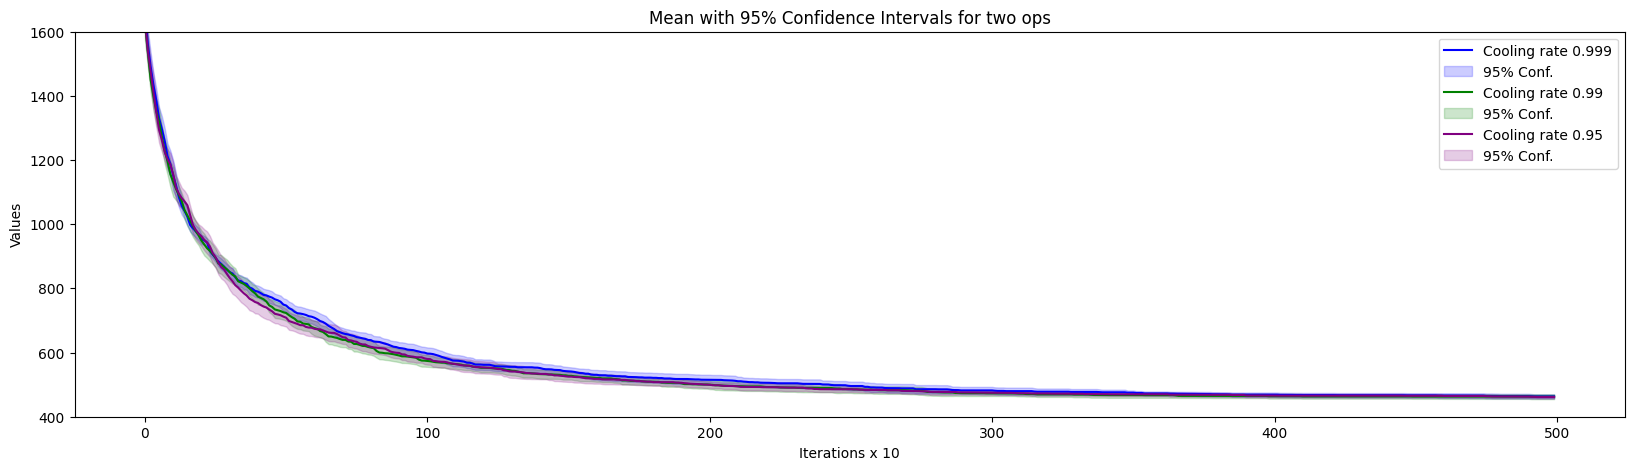

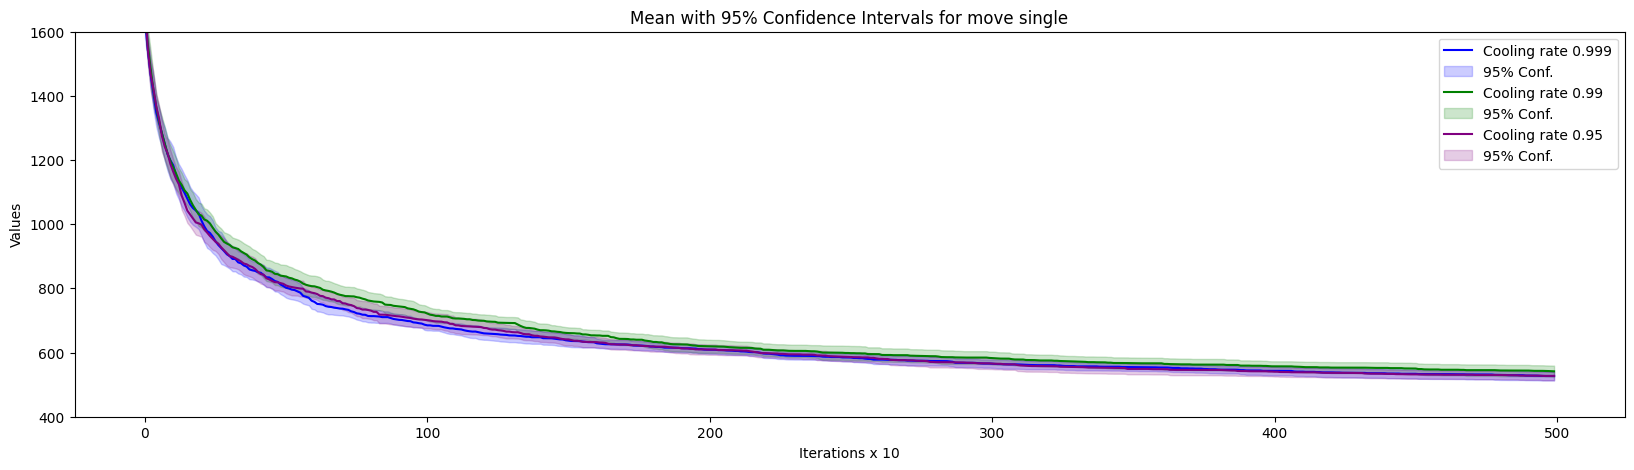

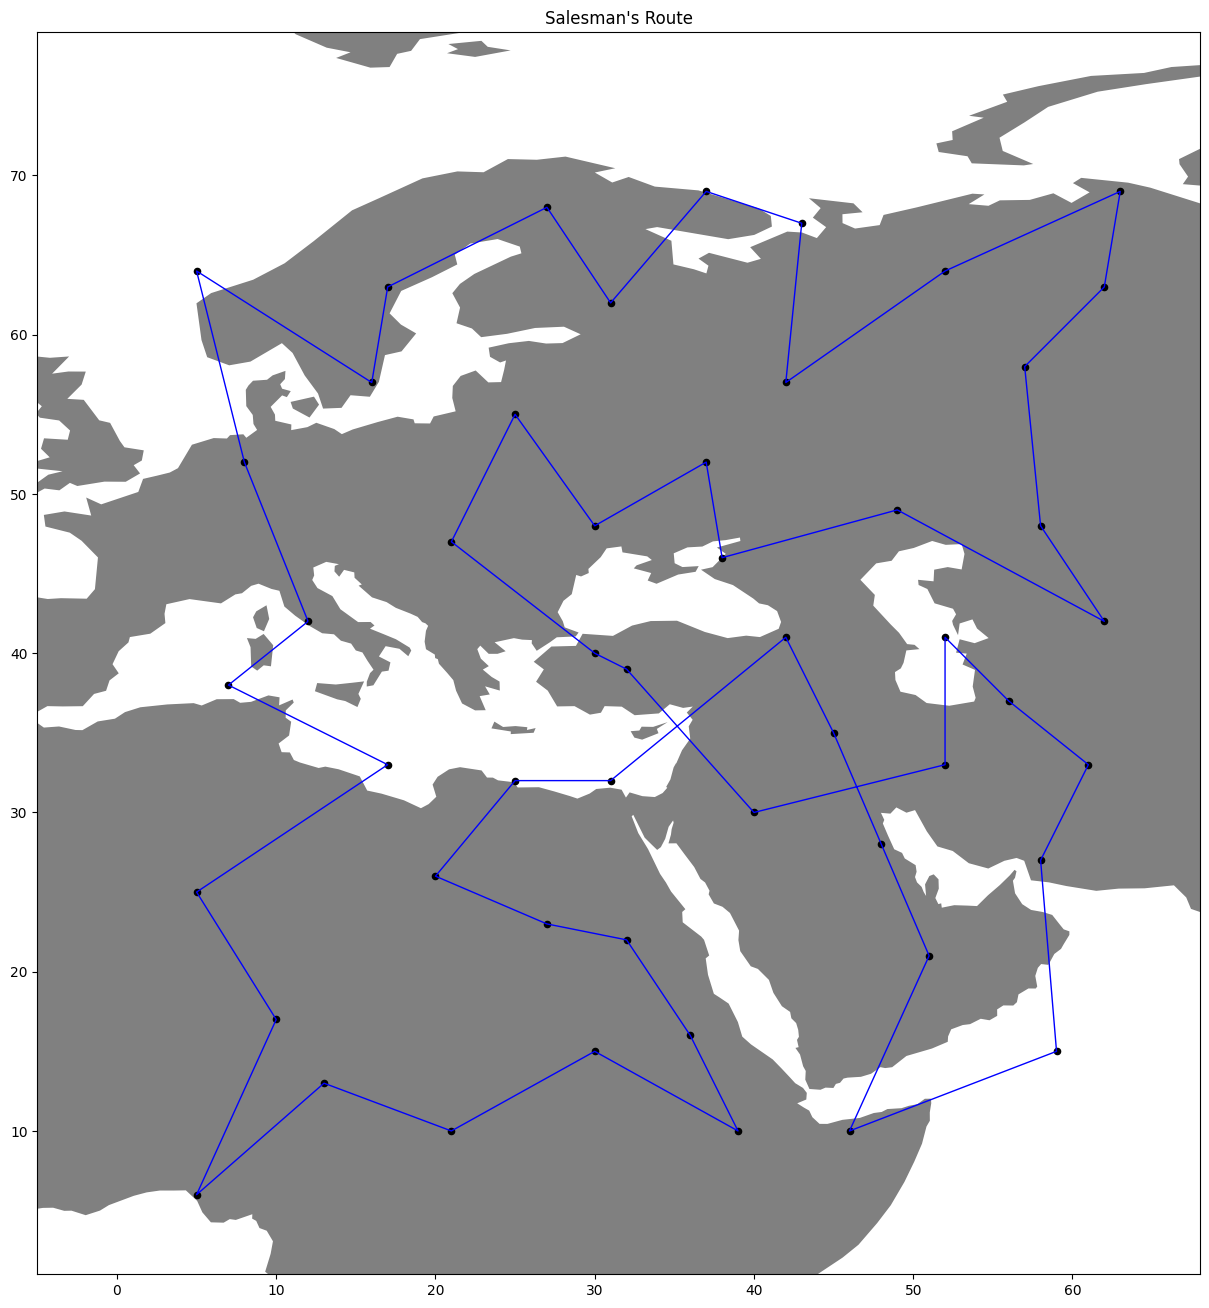

In [9]:
means_two = [two_opt_list[0].give_all_means(), two_opt_list[1].give_all_means(), two_opt_list[2].give_all_means()]
means_single = [move_single_list[0].give_all_means(), move_single_list[1].give_all_means(), move_single_list[2].give_all_means()]
ci_two = [two_opt_list[0].give_all_ci(), two_opt_list[1].give_all_ci(), two_opt_list[2].give_all_ci()]
ci_single = [move_single_list[0].give_all_ci(), move_single_list[1].give_all_ci(), move_single_list[2].give_all_ci()]

iterations = range(two_opt_list[0].range())  

colors = ["blue","green","purple"]
cooling_rates = [0.999, 0.99, 0.95]

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_two):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_two[i]),  
        np.array(mean) + np.array(ci_two[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for two ops")
plt.legend()
plt.ylim(400, 1600)

plt.show()

plt.figure(figsize=(20,5))
for i, mean in enumerate(means_single):
    plt.plot(iterations, mean, label=f"Cooling rate {cooling_rates[i]}", color=colors[i])


    plt.fill_between(
        iterations,
        np.array(mean) - np.array(ci_single[i]),  
        np.array(mean) + np.array(ci_single[i]),  
        color=colors[i],
        alpha=0.2,  
        label="95% Conf."
    )

plt.xlabel(f"Iterations x {annealing.measurement_interval}")
plt.ylabel("Values")
plt.title("Mean with 95% Confidence Intervals for move single")
plt.legend()
plt.ylim(400, 1600)

plt.show()

annealing.final_routes[5].plot()



In [ ]:
class City:
    def __init__(self, city, x, y):
        """
        - city: city integer
        - x coordinate
        - y coordinate
        """
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)
    
    def connects_to(self, city):
        """
        Connects one city to another by adding it to a list
        """
        self.connections.append(city)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    def __init__(self, route, cities):
        self.cities = cities
        self.route = [self.cities[i] for i in route]
        self.route_int = route
        self.distance = self.calculate_distance()
        self.old_route = []

    def two_opt(self):
        """
        """
        self.old_route = self.route
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])
        self.route_int[i + 1:j + 1] = reversed(self.route_int[i + 1:j + 1])

    def calculate_distance(self):
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        return distance
    
    def plot(self):
        route_coordinates = [(city.x, city.y) for city in self.cities]

        # Create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='blue', markersize=15)
        # route
        route_gdf.plot(ax=ax, color='red', linewidth=2)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

In [ ]:
"""Takes approximately 10-12 hours to run this for 700,000 iterations"""

temperatures = [20, 400, 2000]
methods = ["linear", "exponential", "logarithmic"]
results = {m: {} for m in methods}
temp_results = {m: {} for m in methods}
all_runs_data = {}
ci_results = {}
acceptance_rates = {}

for temp in temperatures:
    for method in methods:
        
        annealing = SimmulatedAnnealing(280, "a280.tsp.txt")
        annealing.set_cooling_method(method)
        annealing.init_temp = temp
        annealing.final_temp = 1
        annealing.iterations = 700000
        annealing.measurement_interval = 10
        annealing.perturbation = "two_opt"
        annealing.cooling_rate = 0.95
        print(f"Method: {method} ")
        
        annealing.run(10)
        mean_acceptance_rates = np.mean(annealing.acceptance_rates, axis=0)
        mean_values = annealing.give_all_means()
        mean_temps = annealing.give_all_temps_mean()
        results = mean_values
        temp_results = mean_temps
        ci_results = annealing.give_all_ci()

        all_runs_data = annealing.data

        method_results = {
            "mean_values": mean_values,
            "mean_temps": mean_temps,
            "ci_values": ci_results,
            "all_runs_data": all_runs_data,
            "acceptance_rates": mean_acceptance_rates
        }

        timestamp = int(time.time())
        file_path = f"{method}_temp{annealing.init_temp}_600000iter_results.pkl"
        with open(file_path, "wb") as file:
            pickle.dump(method_results, file)
        print(f"Results for {method} saved to {file_path}")

Method: linear 


100%|██████████| 10/10 [1:57:06<00:00, 702.64s/it]


Results for linear saved to linear_temp20_600000iter_results.pkl
Method: exponential 


100%|██████████| 10/10 [1:55:30<00:00, 693.02s/it]


Results for exponential saved to exponential_temp20_600000iter_results.pkl
Method: logarithmic 


100%|██████████| 10/10 [1:55:32<00:00, 693.26s/it]


Results for logarithmic saved to logarithmic_temp20_600000iter_results.pkl
Method: linear 


100%|██████████| 10/10 [1:16:58<00:00, 461.86s/it]


Results for linear saved to linear_temp400_600000iter_results.pkl
Method: exponential 


100%|██████████| 10/10 [1:40:44<00:00, 604.47s/it]


Results for exponential saved to exponential_temp400_600000iter_results.pkl
Method: logarithmic 


100%|██████████| 10/10 [1:48:16<00:00, 649.62s/it]


Results for logarithmic saved to logarithmic_temp400_600000iter_results.pkl
Method: linear 


100%|██████████| 10/10 [1:07:06<00:00, 402.67s/it]


Results for linear saved to linear_temp2000_600000iter_results.pkl
Method: exponential 


100%|██████████| 10/10 [4:18:55<00:00, 1553.51s/it] 


Results for exponential saved to exponential_temp2000_600000iter_results.pkl
Method: logarithmic 


100%|██████████| 10/10 [2:27:13<00:00, 883.39s/it]  

Results for logarithmic saved to logarithmic_temp2000_600000iter_results.pkl


In [156]:
temperatures = [20, 400, 2000]
methods = ["linear", "exponential", "logarithmic"]

loaded_data = {}

# Load data for each combination of temperature and method
for temp in temperatures:
    loaded_data[temp] = {}
    for method in methods:
        file_path = f"{method}_temp{temp}_600000iter_results.pkl"
        with open(file_path, "rb") as file:
            loaded_data[temp][method] = pickle.load(file)

print("Data loaded successfully!")

Data loaded successfully!


In [127]:
cities = Cities("a280.tsp.txt") 
optimal_tour = load_tour("a280.opt.tour.txt")
optimal_route = [cities.city[city_id - 1] for city_id in optimal_tour]  # -1 since indexes start at 1 in txt file 

distance = 0
for i in range(len(optimal_route) - 1):
    distance += optimal_route[i].get_distance_to(optimal_route[i + 1])

distance += optimal_route[-1].get_distance_to(optimal_route[0])  # Close the loop

print(f"Optimal route distance: {distance}")

Optimal route distance: 2586.7696475631606


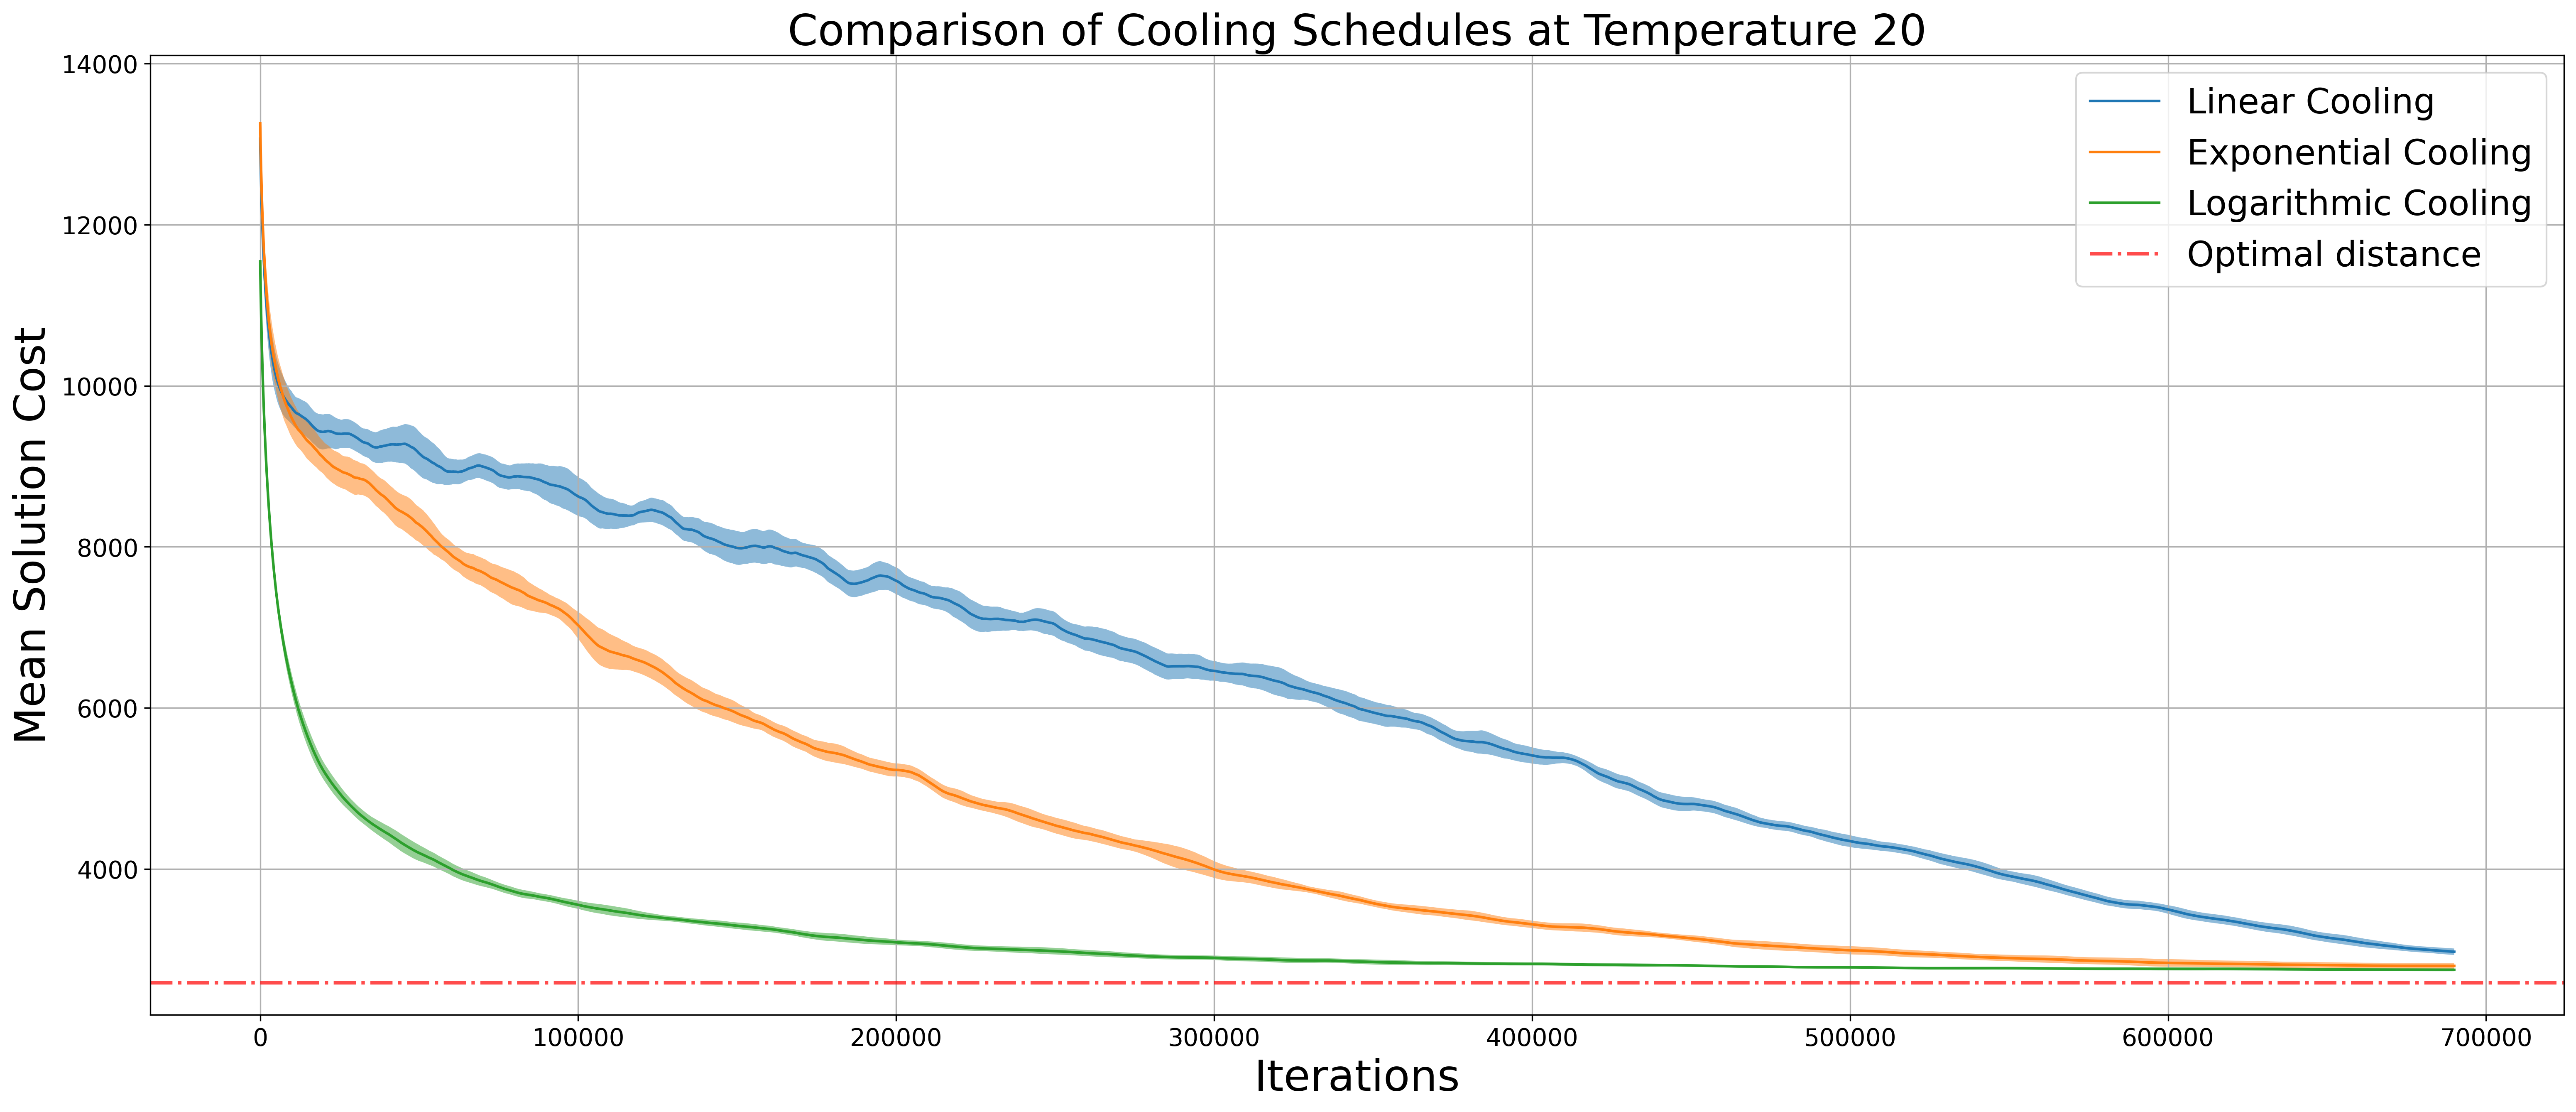

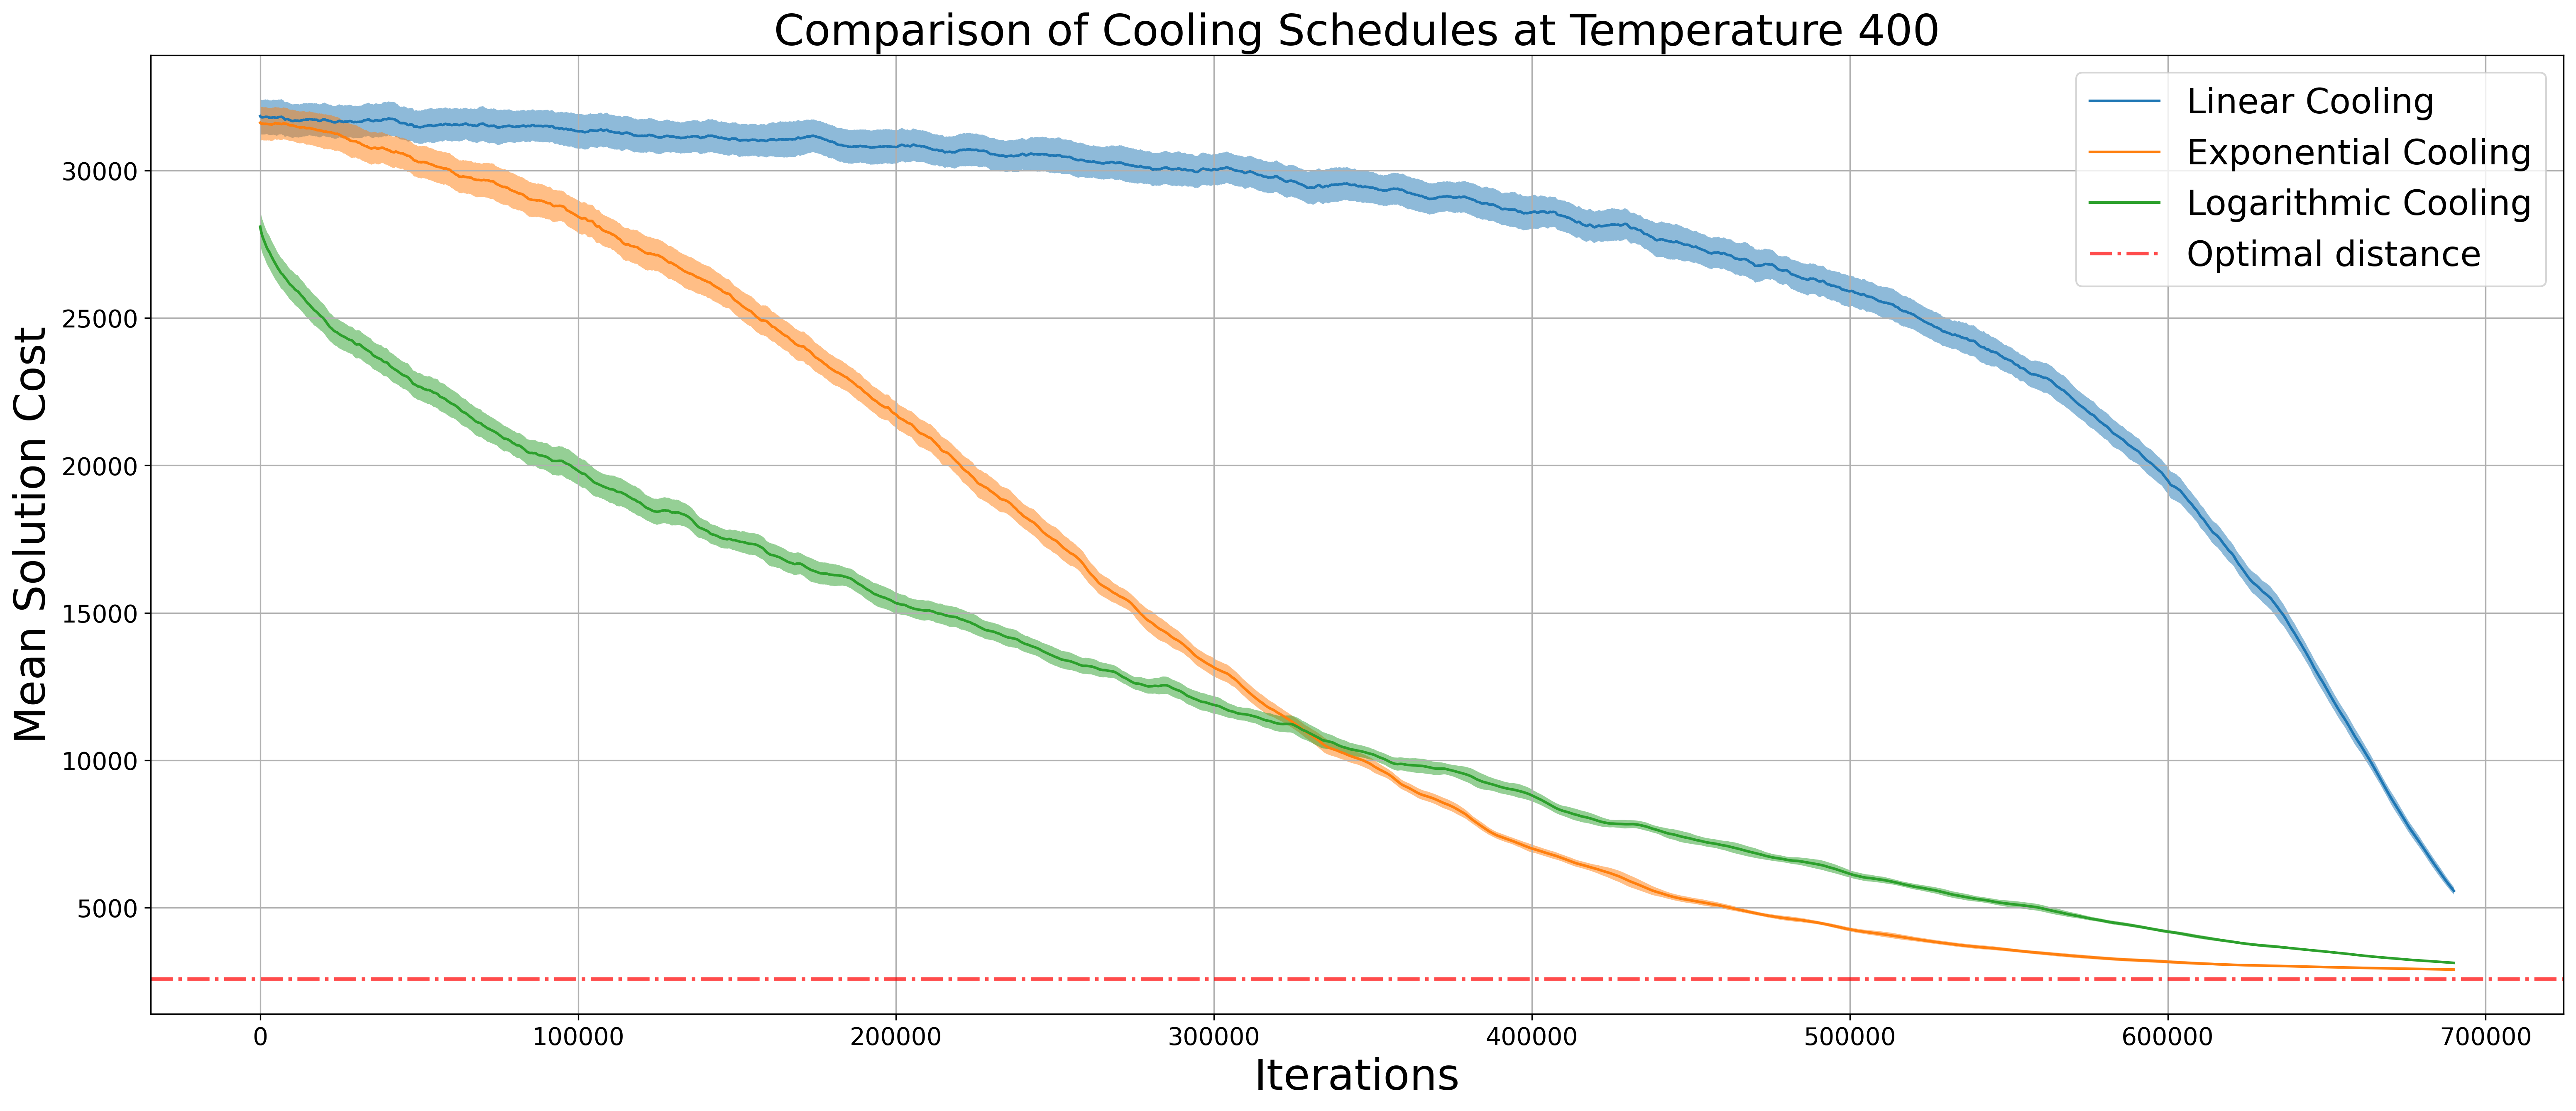

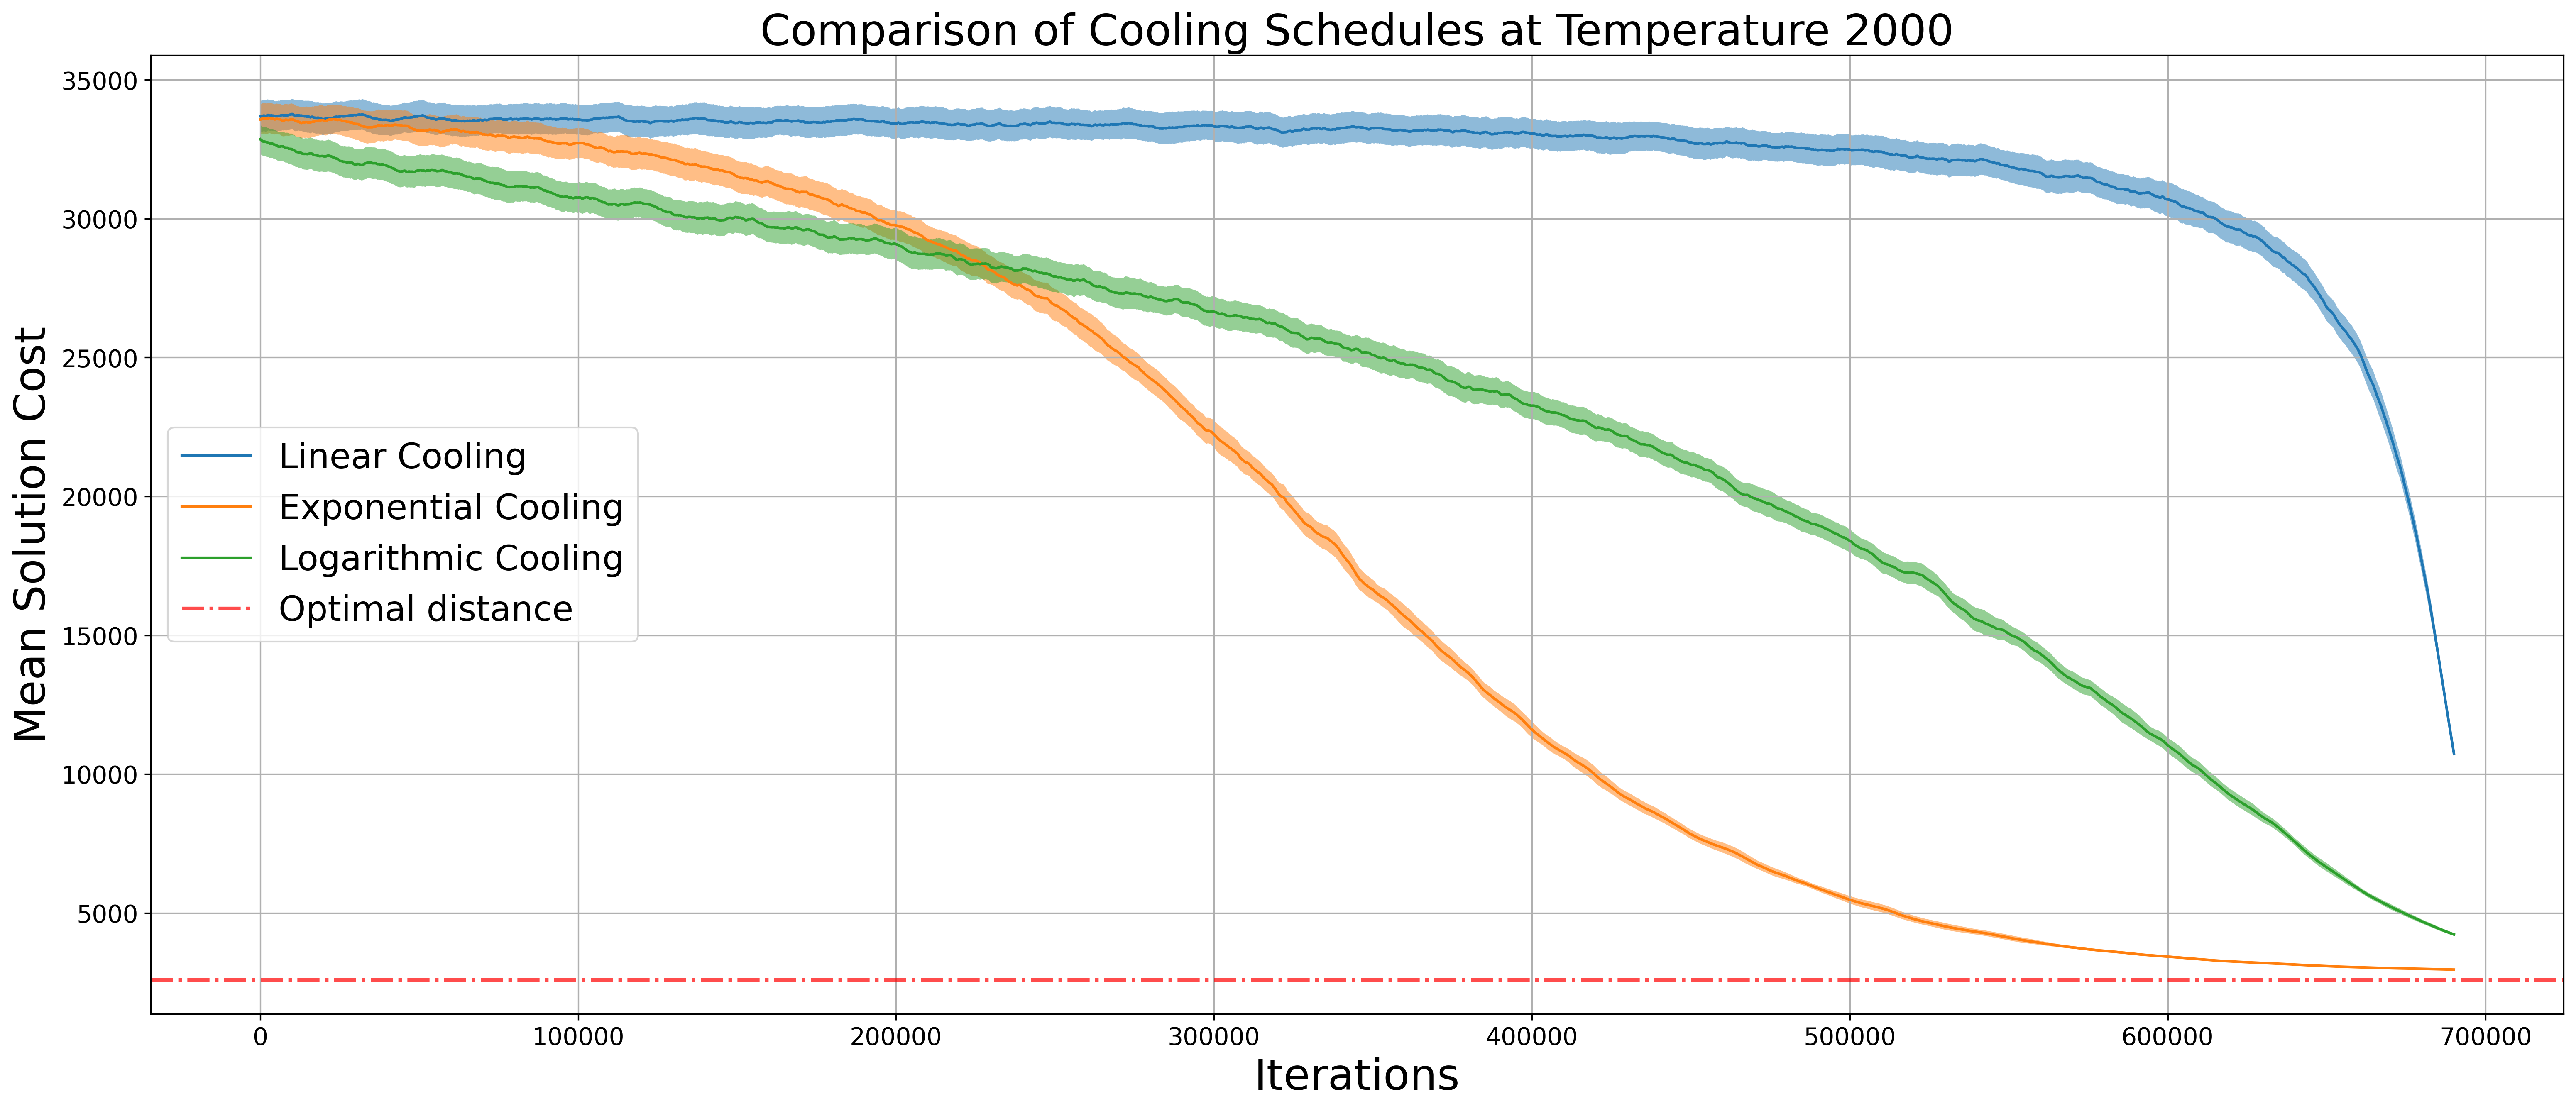

Lowest mean values for each method and temperature:
Temperature 20:
  linear: 2971.5254722453674
  exponential: 2795.79897084317
  logarithmic: 2746.7920921942796
Temperature 400:
  linear: 5570.242184144216
  exponential: 2901.8560346415616
  logarithmic: 3128.1279135164314
Temperature 2000:
  linear: 10746.853937956334
  exponential: 2959.2428227184123
  logarithmic: 4224.5179202643685


In [157]:
def moving_average(data, window_size):
    """Method for smoothing out the moving average"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

temperatures = [20, 400, 2000]
methods = ["linear", "exponential", "logarithmic"]
measurement_interval = 10
iterations = 700000
x_axis = np.arange(0, iterations, measurement_interval)

lowest_mean_values = {}

# Create separate plots for each temperature
for temp in temperatures:
    plt.figure(figsize=(25,10), dpi=300)
    lowest_mean_values.setdefault(temp, {})
    
    for method in methods:
        # Extract mean values for this method and temperature
        mean_values = loaded_data[temp][method]["mean_values"]
        ci_values = loaded_data[temp][method]["ci_values"]

        window_size = 1000
        smoothed_mean_values = moving_average(mean_values, window_size)
        smoothed_ci_values = moving_average(ci_values, window_size)
        x_axis_smoothed = x_axis[:len(smoothed_mean_values)]

        # Calculate smoothed bounds for confidence intervals
        lower_bound_smoothed = smoothed_mean_values - smoothed_ci_values
        upper_bound_smoothed = smoothed_mean_values + smoothed_ci_values

        
        plt.plot(x_axis_smoothed, smoothed_mean_values, label=f"{method.capitalize()} Cooling")
        lower_bound = np.array(smoothed_mean_values) - np.array(smoothed_ci_values)
        upper_bound = np.array(smoothed_mean_values) + np.array(smoothed_ci_values)
        
        lowest_mean_value = min(smoothed_mean_values)
        lowest_mean_values[temp][method] = lowest_mean_value  # Store it in the dictionary

        plt.fill_between(x_axis_smoothed, lower_bound_smoothed, upper_bound_smoothed, alpha=0.5)
        
    plt.axhline(y=distance, color='red', linestyle='-.', linewidth=2, alpha=0.7, label='Optimal distance')


    
    plt.title(f"Comparison of Cooling Schedules at Temperature {temp}", fontsize=25)
    plt.xlabel("Iterations", fontsize=25)
    plt.ylabel("Mean Solution Cost", fontsize=25)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

#Print lowest mean values for each initial temperature and cooling schedule
print("Lowest mean values for each method and temperature:")
for temp, methods in lowest_mean_values.items():
    print(f"Temperature {temp}:")
    for method, value in methods.items():
        print(f"  {method}: {value}")

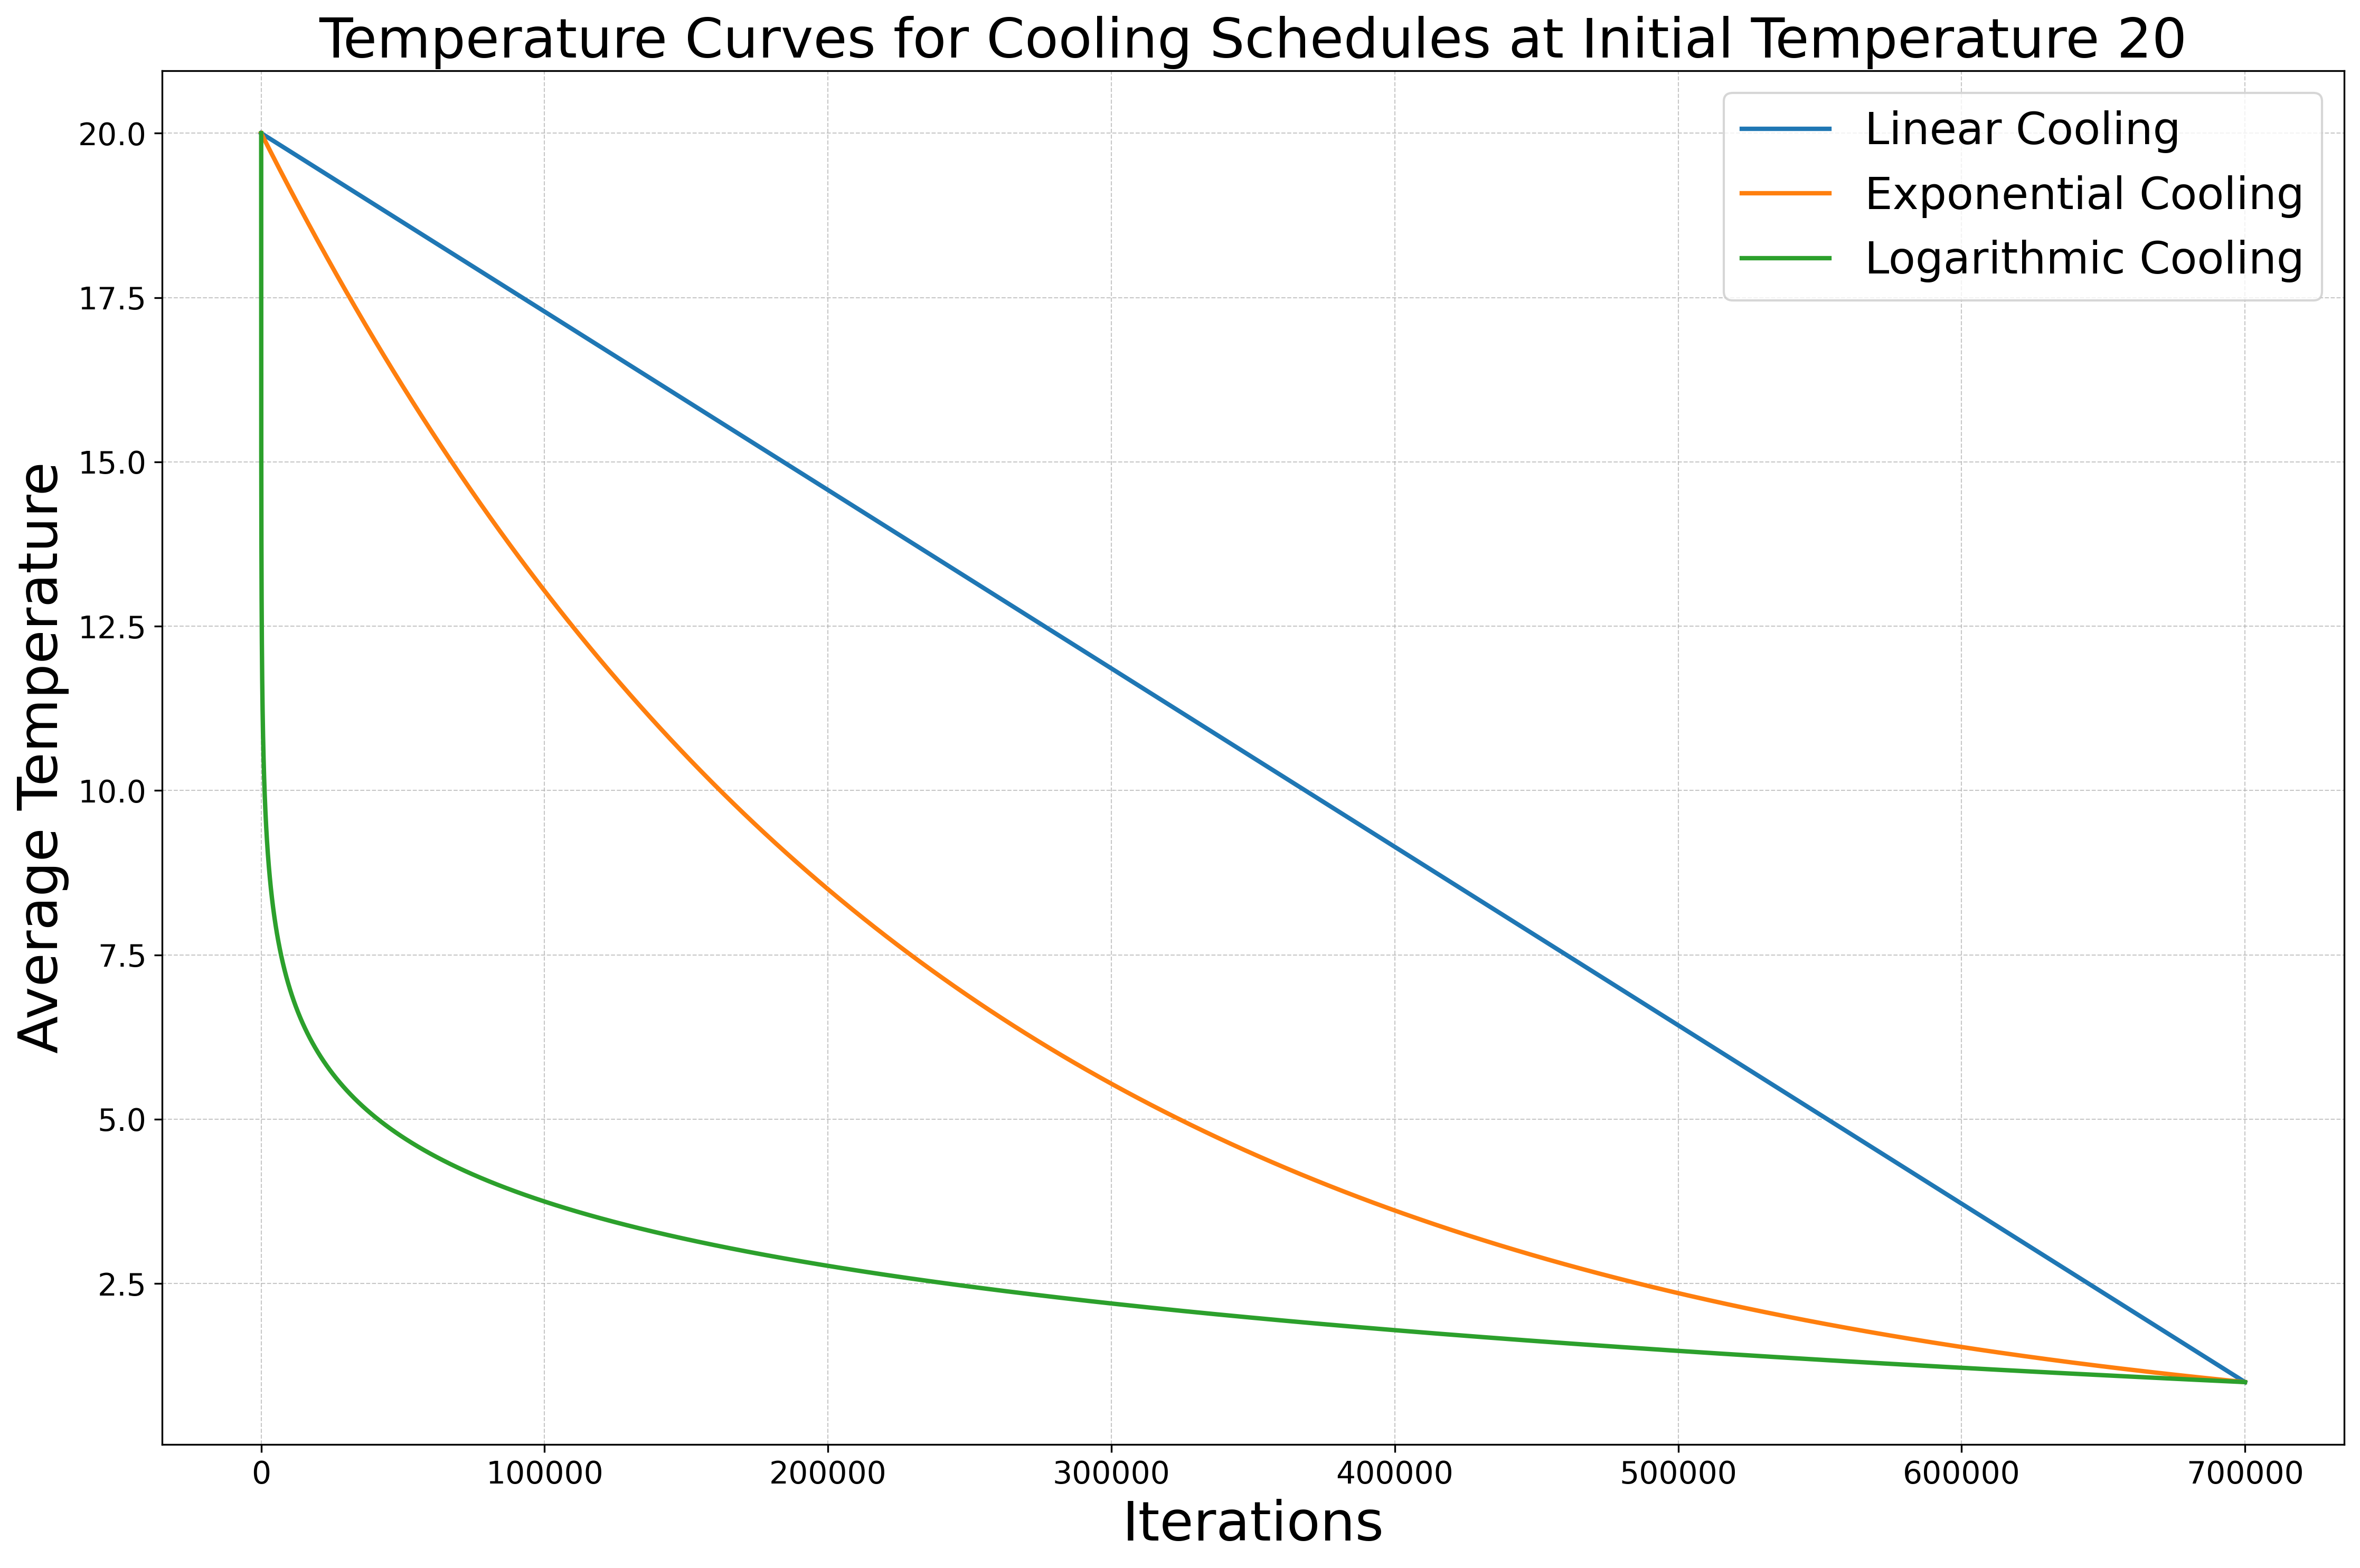

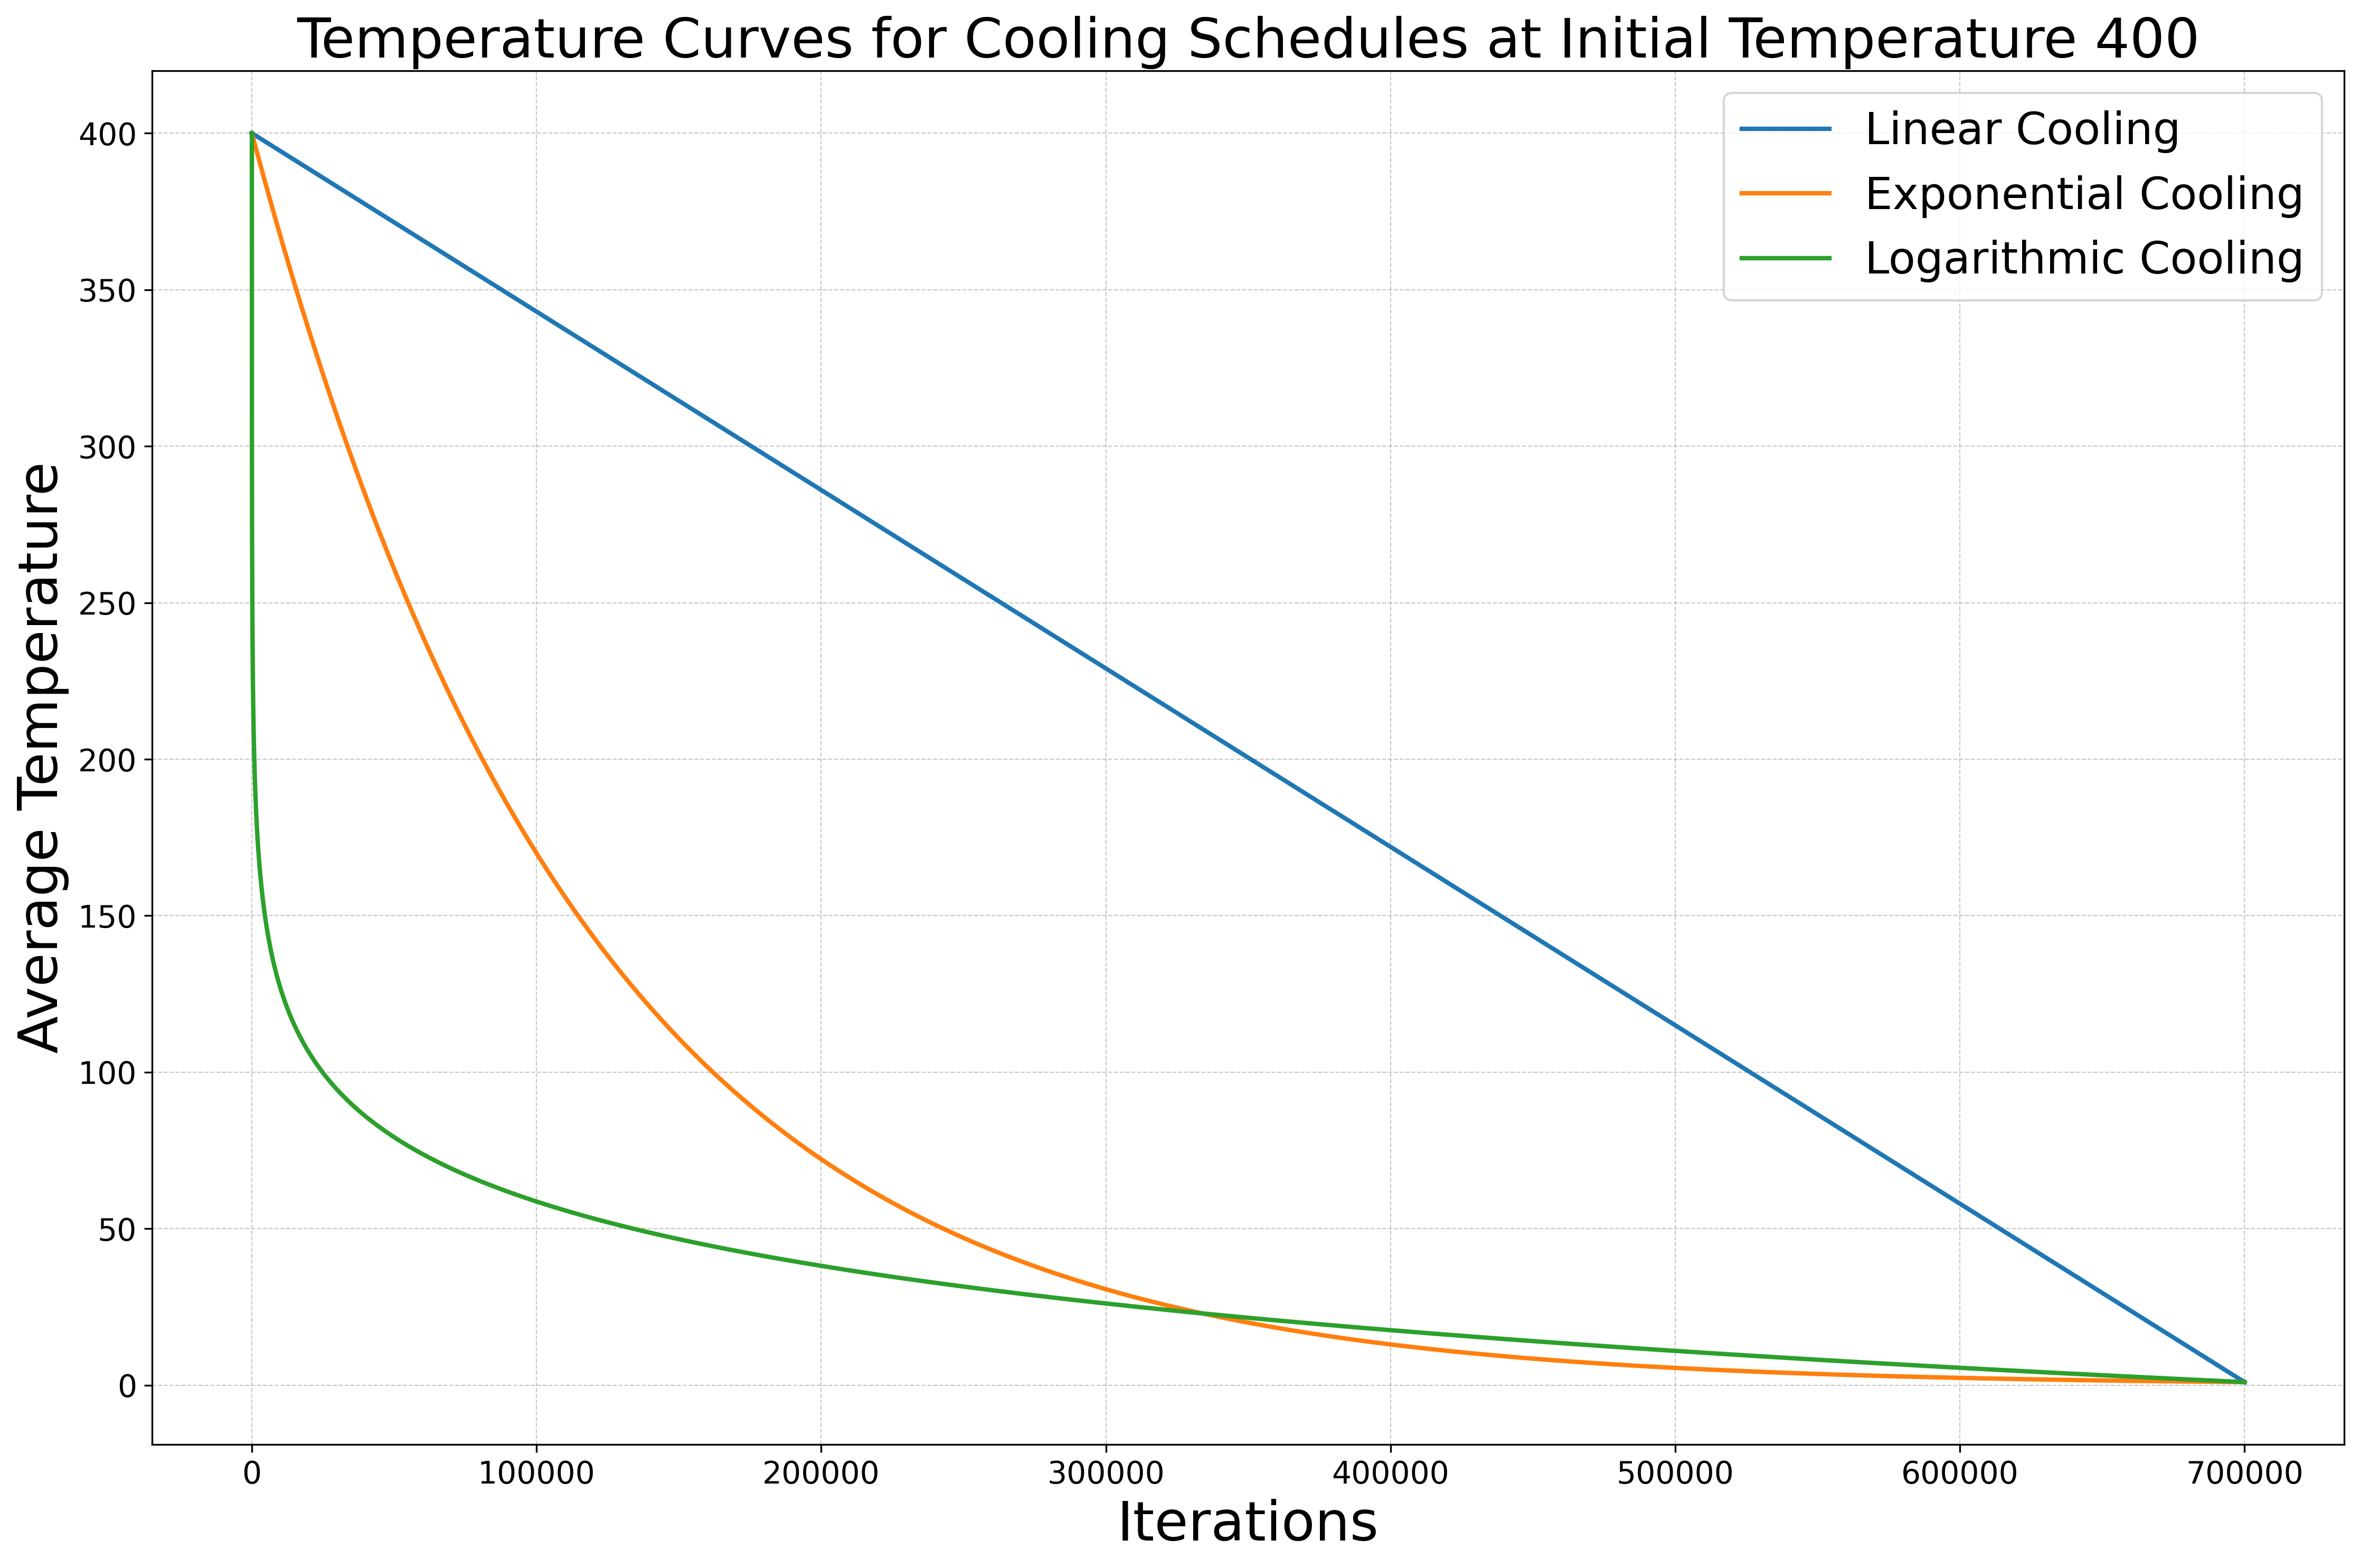

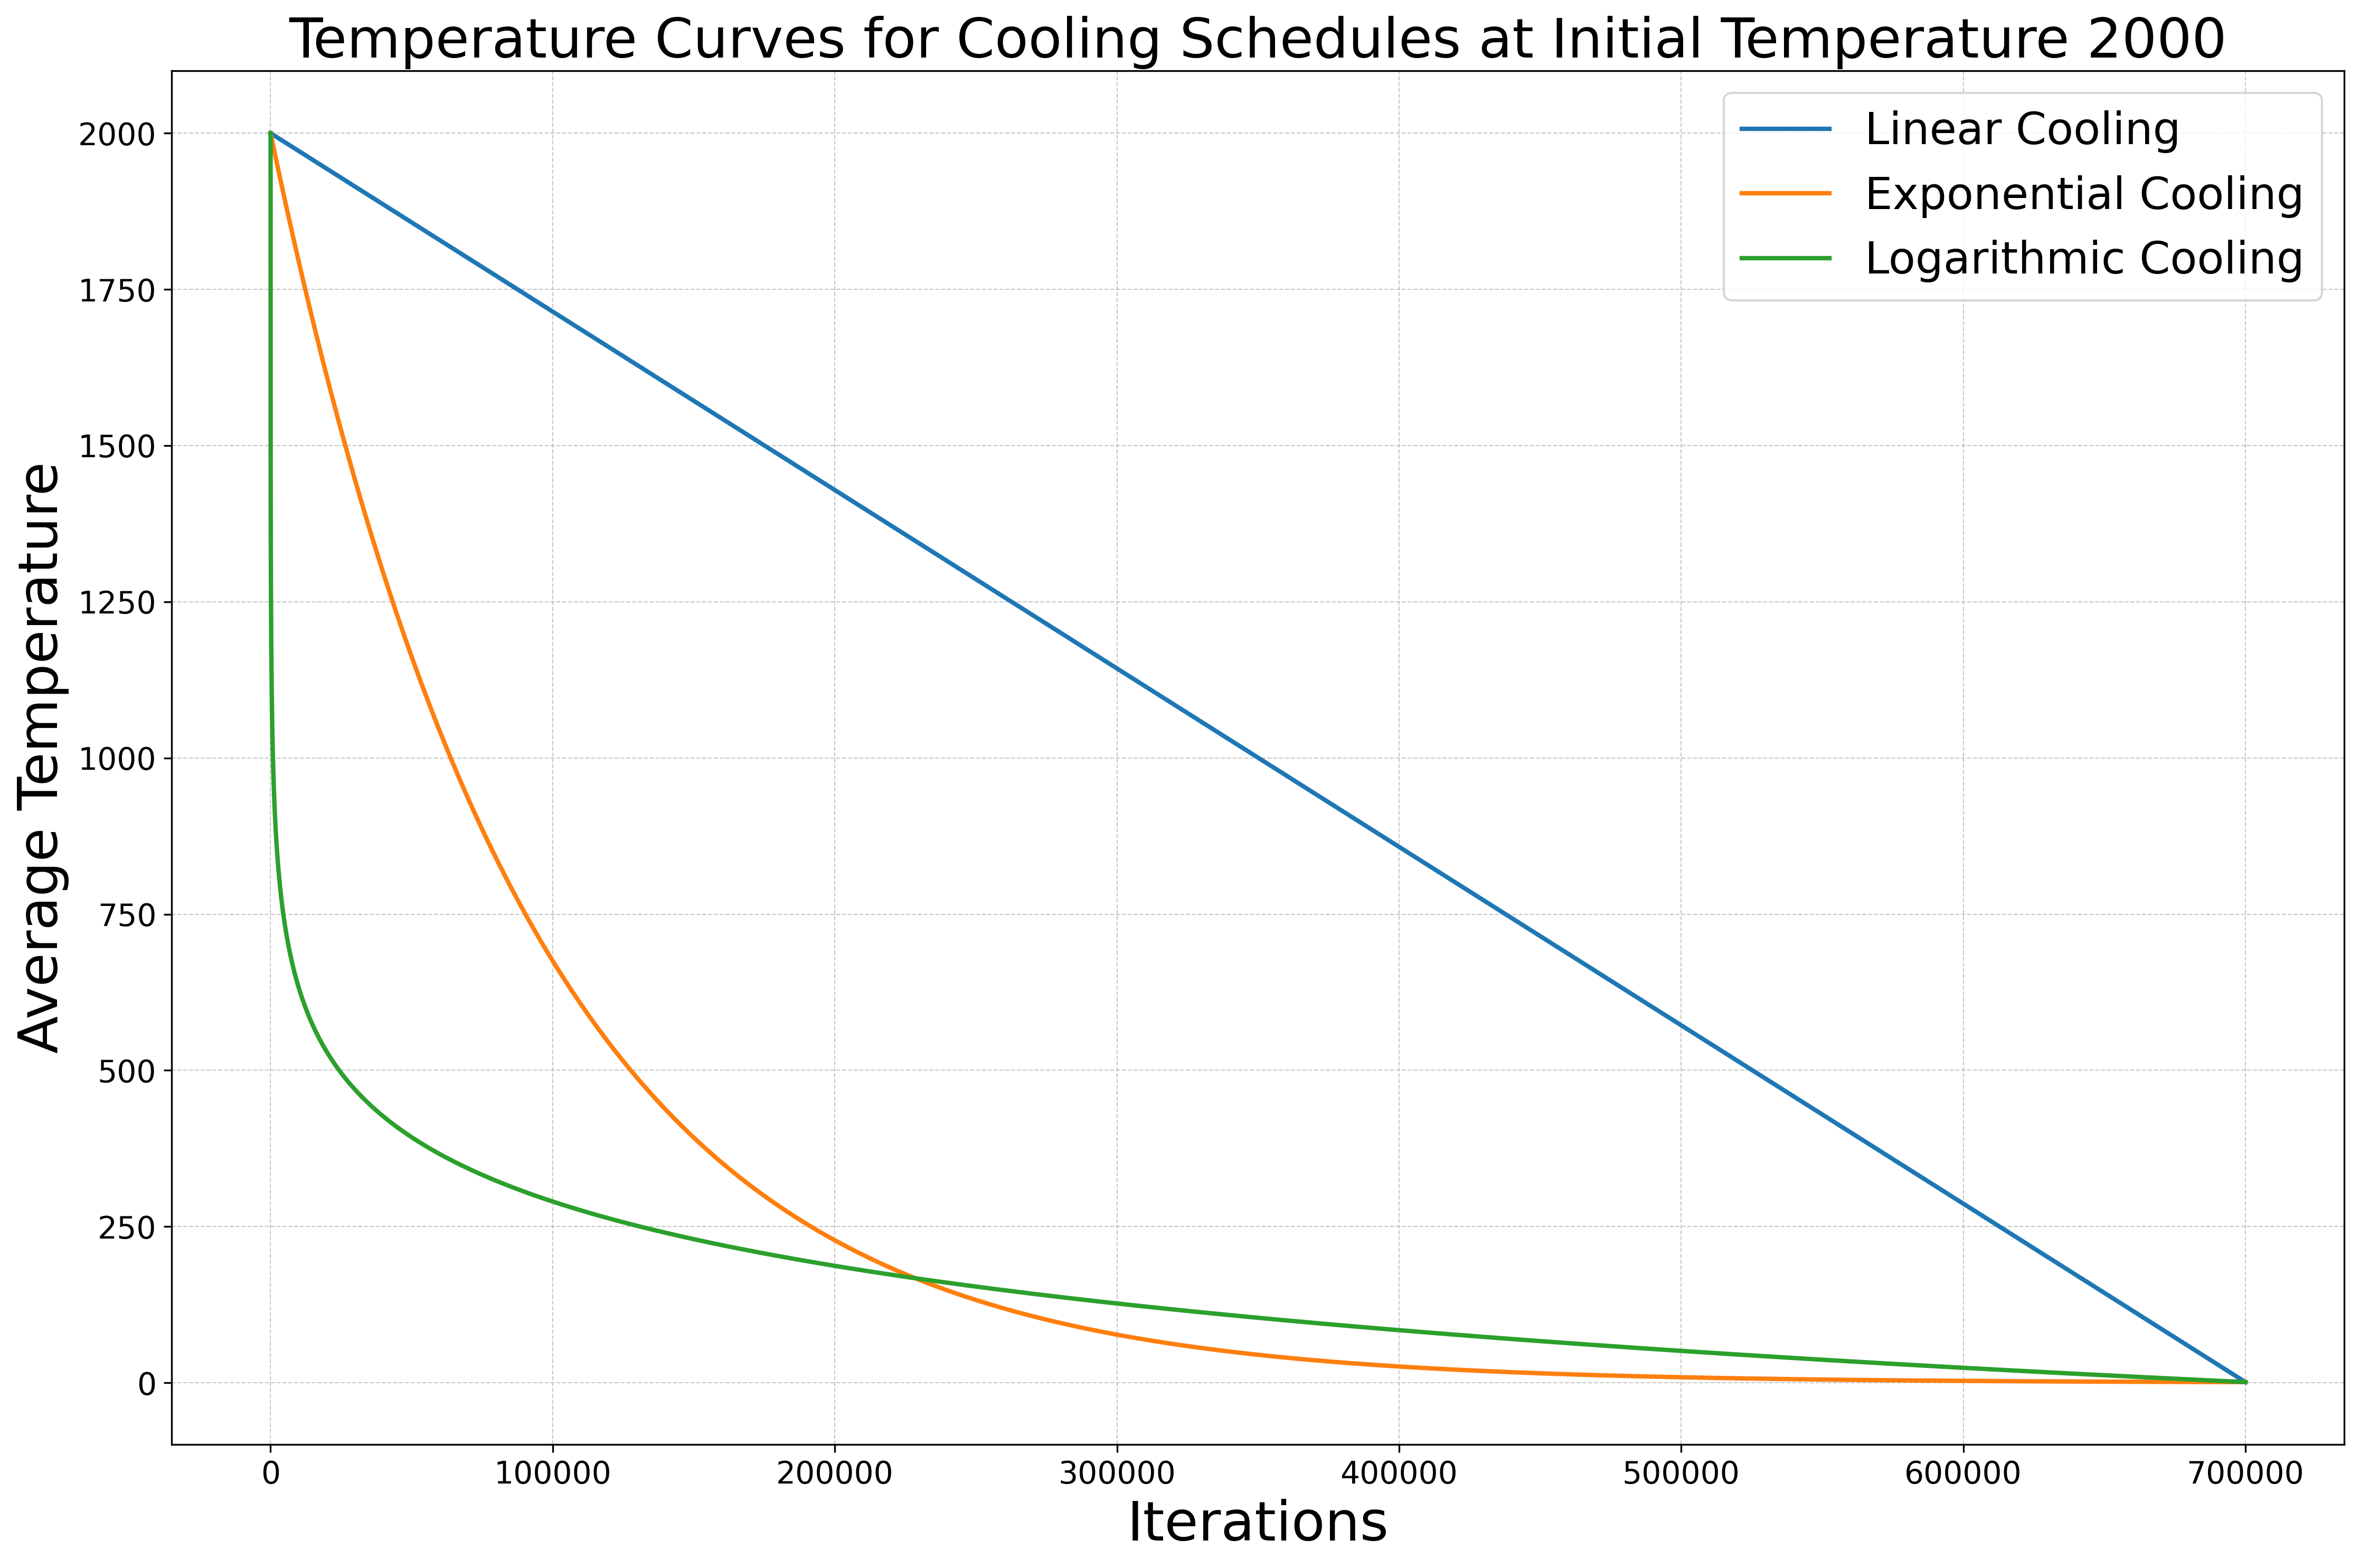

In [ ]:
for temp in temperatures:
    plt.figure(figsize=(15, 10), dpi=300)
    
    for method in methods:
        if method not in loaded_data[temp]:
            continue 
        
        mean_temps = loaded_data[temp][method]["mean_temps"]
        plt.plot(x_axis, mean_temps, label=f"{method.capitalize()} Cooling", linewidth=2)
    
    plt.title(f"Temperature Curves for Cooling Schedules at Initial Temperature {temp}", fontsize=25)
    plt.xlabel("Iterations", fontsize=25)
    plt.ylabel("Average Temperature", fontsize=25)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
methods = ["linear", "exponential", "logarithmic"]
temperatures = [20, 400, 2000]

loaded_data = {}

# Load data
for temp in temperatures:
    loaded_data[temp] = {}
    for method in methods:
        file_path = f"{method}_temp{temp}_600000iter_results.pkl"
        try:
            with open(file_path, "rb") as file:
                loaded_data[temp][method] = pickle.load(file)
            print(f"Loaded data from {file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

Loaded data from linear_temp20_600000iter_results.pkl
Loaded data from exponential_temp20_600000iter_results.pkl
Loaded data from logarithmic_temp20_600000iter_results.pkl
Loaded data from linear_temp400_600000iter_results.pkl
Loaded data from exponential_temp400_600000iter_results.pkl
Loaded data from logarithmic_temp400_600000iter_results.pkl
Loaded data from linear_temp2000_600000iter_results.pkl
Loaded data from exponential_temp2000_600000iter_results.pkl
Loaded data from logarithmic_temp2000_600000iter_results.pkl


In [ ]:
#Store all_runs_data in a dictionary in a way that we can use it to perform t-tests

final_values = {}
num_runs = 10
num_iterations = 70000 #number of iterations was 700000 but the measurement interval 10, thus 70000 data points per run.
summary_iterations = 1000

for temp in temperatures:
    for method in methods:
        all_runs_data = loaded_data[temp][method]['all_runs_data']
        
        if all_runs_data.shape != (num_runs, num_iterations):
            raise ValueError(f"Unexpected shape for {method} at temp {temp}: {all_runs_data.shape}")
        
        # Compute the mean of the last 1000 iterations
        run_summaries = np.mean(all_runs_data[:, -summary_iterations:], axis=1)
        
        # Store the summaries
        final_values[(method, temp)] = run_summaries

In [155]:
methods = ["linear", "exponential", "logarithmic"]
temperatures = [20, 400, 2000]

t_test_results = []

# Define pairs of methods to compare (linear, exponential) (logarithmic, exponential) (linear, logarithmic)
method_pairs = list(combinations(methods, 2))  


for temp in temperatures:
    for (method1, method2) in method_pairs:
        group1 = final_values[(method1, temp)]
        group2 = final_values[(method2, temp)]
        
        # Perform a t-test
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        
        
        # Append the results to the list
        t_test_results.append([
            f"{method1.capitalize()} vs. {method2.capitalize()} at Temp {temp}",
            round(t_stat, 4),
            f"{p_val:.2e}"
        ])


df_t_tests = pd.DataFrame(t_test_results, columns=["Comparison", "t-statistic", "p-value"])

# Use tabulate to format it neatly in a table
table = tabulate(df_t_tests, headers="keys", tablefmt="pretty", showindex=False)

print(table)

+------------------------------------------+-------------+----------+
|                Comparison                | t-statistic | p-value  |
+------------------------------------------+-------------+----------+
|    Linear vs. Exponential at Temp 20     |   6.1157    | 9.58e-06 |
|    Linear vs. Logarithmic at Temp 20     |   9.5478    | 4.97e-07 |
|  Exponential vs. Logarithmic at Temp 20  |   2.3196    | 3.71e-02 |
|    Linear vs. Exponential at Temp 400    |   41.0501   | 1.79e-12 |
|    Linear vs. Logarithmic at Temp 400    |   37.8241   | 6.78e-12 |
| Exponential vs. Logarithmic at Temp 400  |  -11.5152   | 1.25e-09 |
|   Linear vs. Exponential at Temp 2000    |  150.8689   | 4.38e-19 |
|   Linear vs. Logarithmic at Temp 2000    |  118.7675   | 3.62e-21 |
| Exponential vs. Logarithmic at Temp 2000 |  -44.6498   | 1.84e-17 |
+------------------------------------------+-------------+----------+
